# Frugal Flow Validation

In this notebook we perform a series of checks to confirm that the Flow's are indeed correctly modelling the desired effects!

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as ss
import seaborn as sns
from sklearn.model_selection import KFold

from data.create_sim_data import simulate_data
from frugal_flows.causal_flows import get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

jax.config.update("jax_enable_x64", True)

## Generating Data

In [2]:
N = 2000
corr_matrix = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.4],
    [0.6, 0.4, 1]
])
marginal_Z = {
    'Z1': ss.norm(loc=10, scale=3),
    'Z2': ss.norm(loc=10, scale=3)
}
prop_score_weights = [0, 0]  # Check propscore weights are of same dim as Z
causal_params = [1, 1]
treatment_type = "D"
outcome_type = "C"

### Marginal CDF Inference

First we validate the inference of the CDFs jointly. First when $Z_1$ and $Z_2$ both have $\mu = 3$

In [3]:
marginal_Z = {
    'Z1': ss.norm(loc=10, scale=3),
    'Z2': ss.norm(loc=10, scale=3)
}
data_xdyc = simulate_data(N, corr_matrix, marginal_Z, prop_score_weights, "D", causal_params, "C")
df_Z = data_xdyc[['Z1', 'Z2']].values
Y = data_xdyc[['Y']].values
X = data_xdyc[['X']].values

res = get_independent_quantiles(
    key = jr.PRNGKey(1),
    z_cont=jnp.array(df_Z),
    # z_discr=
    learning_rate=1e-3,
    RQS_knots=8,
    flow_layers=8,
    nn_width=10,
    nn_depth=1,
    max_epochs = 1000,
    max_patience=100,
    return_z_cont_flow = True,
 )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.55it/s, train=5.089668516788585, val=5.044889185865622]


[[nan nan]
 [nan nan]]


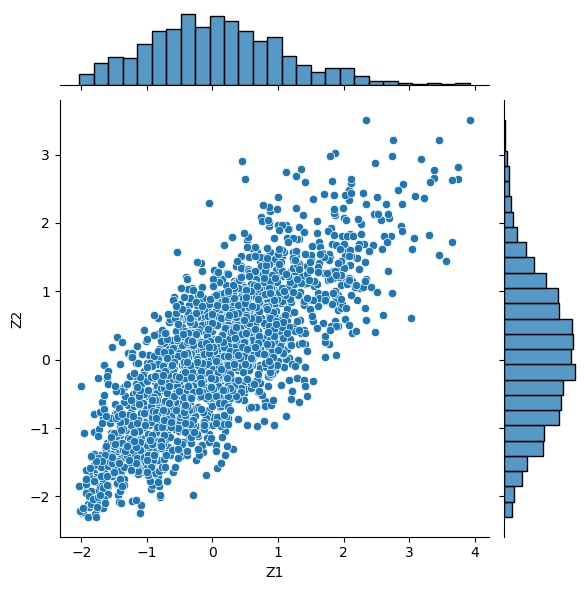

In [4]:
zscore_z_cont = jax.scipy.special.ndtri(res['u_z_cont'])
print(jnp.cov(zscore_z_cont.T))
plot_data = pd.DataFrame(zscore_z_cont, columns=['Z1', 'Z2'])
sns.jointplot(x='Z1', y='Z2', data=plot_data, kind="scatter")

Mean: [9.59033165 9.76767899]
Covariance:
 [[10.13499223  0.02280733]
 [ 0.02280733 10.18593558]]


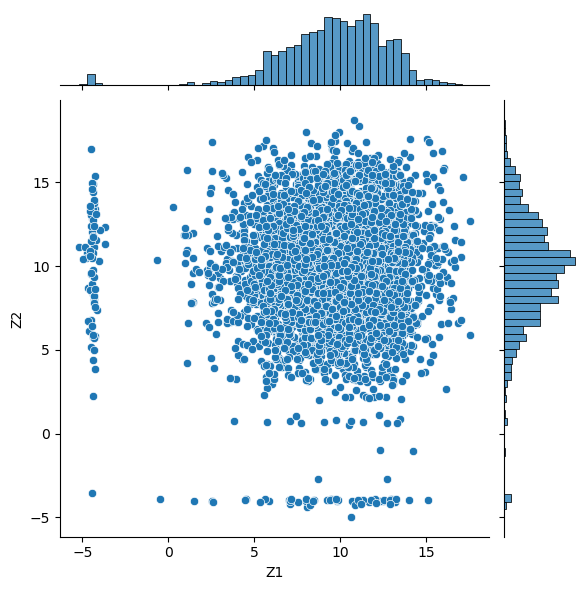

In [5]:
z_samples = res['z_cont_flow'].sample(key=jr.PRNGKey(1), sample_shape=(5000,))
print(f"Mean: {z_samples.mean(axis=0)}")
print(f"Covariance:\n {np.cov(z_samples.T)}")
plot_data = pd.DataFrame(z_samples, columns=['Z1', 'Z2'])
sns.jointplot(x='Z1', y='Z2', data=plot_data, kind="scatter")

Conclusion: Several Boundary issues at $x=-3$ and $y = -3$ WHATS GOING ON

##### TRYING Again but standardising the mean (zero mean)

In [6]:
marginal_Z = {
    'Z1': ss.norm(loc=0, scale=3),
    'Z2': ss.norm(loc=0, scale=3)
}

data_xdyc = simulate_data(N, corr_matrix, marginal_Z, prop_score_weights, "D", causal_params, "C")
df_Z = data_xdyc[['Z1', 'Z2']].values
Y = data_xdyc[['Y']].values
X = data_xdyc[['X']].values

res = get_independent_quantiles(
    key = jr.PRNGKey(1),
    z_cont=jnp.array(df_Z),
    learning_rate=1e-3,
    RQS_knots=8,
    max_epochs = 1000,
    max_patience=100,
    return_z_cont_flow = True,
 )

 18%|█████████████████▌                                                                                  | 176/1000 [00:14<01:06, 12.36it/s, train=5.043311571491139, val=5.108345019677689 (Max patience reached)]


[[1.07931005 0.86093893]
 [0.86093893 1.08614424]]


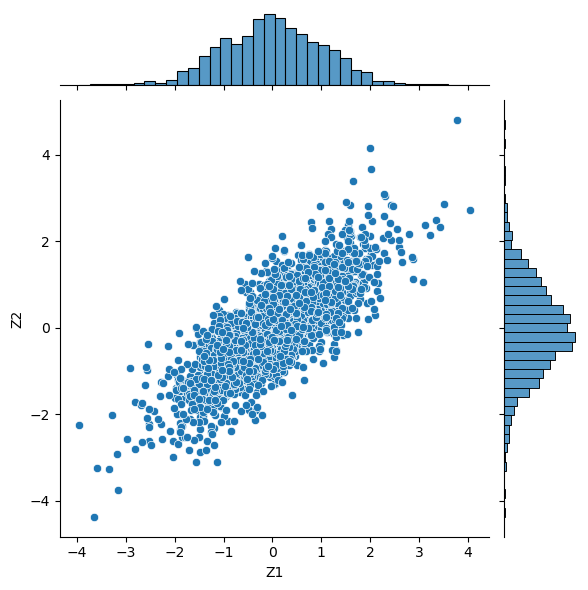

In [7]:
zscore_z_cont = jax.scipy.special.ndtri(res['u_z_cont'])
print(jnp.cov(zscore_z_cont.T))
plot_data = pd.DataFrame(zscore_z_cont, columns=['Z1', 'Z2'])
sns.jointplot(x='Z1', y='Z2', data=plot_data, kind="scatter")

Better! What happens if we standardise the variance?

In [8]:
marginal_Z = {
    'Z1': ss.norm(loc=0, scale=1),
    'Z2': ss.norm(loc=0, scale=1),
    'Z3': ss.norm(loc=0, scale=1),
    'Z4': ss.norm(loc=0, scale=1)
}
data_xdyc = simulate_data(N, corr_matrix, marginal_Z, prop_score_weights, "D", causal_params, "C")
df_Z = data_xdyc[['Z1', 'Z2']].values
Y = data_xdyc[['Y']].values
X = data_xdyc[['X']].values

res = get_independent_quantiles(
    key = jr.PRNGKey(1),
    z_cont=jnp.array(df_Z),
    learning_rate=1e-3,
    RQS_knots=8,
    max_epochs = 1000,
    max_patience=100,
    return_z_cont_flow = True,
 )

 21%|█████████████████████▎                                                                              | 213/1000 [00:15<00:57, 13.77it/s, train=2.856475362217512, val=2.823476452163673 (Max patience reached)]


[[1.04818757 0.81700847]
 [0.81700847 1.00411424]]


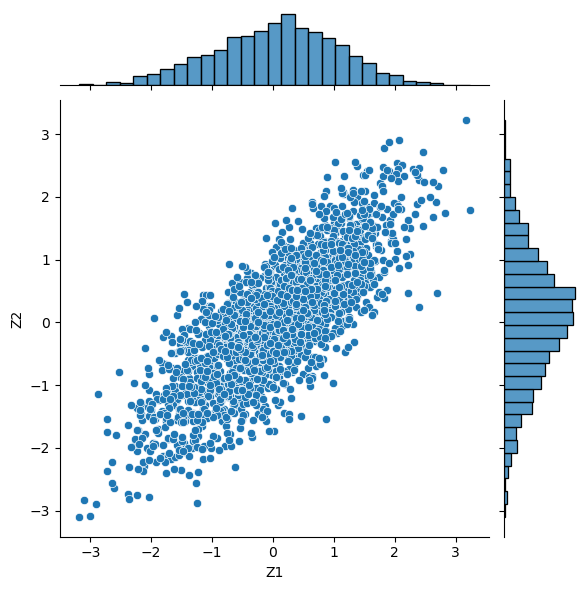

In [9]:
zscore_z_cont = jax.scipy.special.ndtri(res['u_z_cont'])
print(jnp.cov(zscore_z_cont.T))
plot_data = pd.DataFrame(zscore_z_cont, columns=['Z1', 'Z2'])
sns.jointplot(x='Z1', y='Z2', data=plot_data, kind="scatter")

[[1.04818757 0.81700847]
 [0.81700847 1.00411424]]
[[1.        0.7963711]
 [0.7963711 1.       ]]


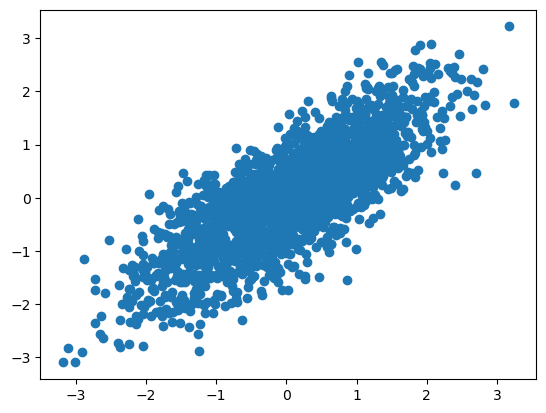

In [10]:
zscore_z_cont = jax.scipy.special.ndtri(res['u_z_cont'])
print(jnp.cov(zscore_z_cont.T))
print(jnp.corrcoef(zscore_z_cont.T))
plt.scatter(*zscore_z_cont.T);

Sort of OK! Although some imperfections remain.

Why no correlation?